In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm as Norm

from os import listdir
from os.path import join

In [2]:
def imread(path):
    return np.array([cv2.imread(join(path, file), cv2.IMREAD_COLOR) for file in sorted(listdir(path))])

def center_crop(img, ratio=0.1):
    h, w = img.shape[:-1]
    h, w = int(h*ratio), int(w*ratio)
    return img[h:-h, w:-w]

def indices_sampling(images, size=50):
    # return a random-sampling indices (in 1-d representation)
    
    # avoid sampling edge points
    #img = cv2.GaussianBlur(images[len(images)//2], (3, 3), 0)
    canny = cv2.Canny(cv2.cvtColor(images[len(images)//2], cv2.COLOR_BGR2GRAY), 10, 30)
    edge_idx = np.ravel_multi_index(np.argwhere(canny > 128).T, canny.shape)

    # sampling points with the largest standard deviation
    tmp = images.mean(axis=-1).reshape(images.shape[0], -1)
    tmp[:, edge_idx] = 0
    return np.random.choice(tmp.std(axis=0).argsort()[::-1][:size*2], size, replace=False)

def get_windows():
    return np.array([x if x <= 127.5 else 255-x for x in range(256)])

In [23]:
def debevec(Z, T, l, w):
    N, P = Z.shape
    
    # fill-in A matrix (by avoiding the for-loop)
    A11 = np.zeros((N*P, 256))
    A12 = np.zeros((N*P, N))
    A_mid = np.zeros(256+N)
    A21 = np.zeros((254, 256))
    A22 = np.zeros((254, N))
    
    idx = np.arange(N*P)
    Zf = Z.flatten()
    A11[idx, Zf] = w[Zf]
    A12[idx, np.tile(np.arange(N), (P, 1)).T.flatten()] = -w[Zf]
    A_mid[128] = 1
    idx = np.arange(254)
    A21[idx, idx] = l*w[idx+1]
    A21[idx, idx+1] = -2*l*w[idx+1]
    A21[idx, idx+2] = l*w[idx+1]
    
    A = np.r_[np.c_[A11, A12], A_mid.reshape(1, -1), np.c_[A21, A22]]
    B = np.r_[w[Zf]*np.tile(T, (1, N)).squeeze(), np.zeros(255)]
    
    g = np.linalg.pinv(A).dot(B)
    return g[:256], g[256:]

def another_debevec(Z, T, l, w):
    N, P = Z.shape
    
    A = np.zeros((N*P+257, 256+N))
    B = np.zeros((N*P+257, 1))
    
    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w[Z[i, j]]
            A[k, Z[i, j]] = wij
            A[k, 256+i] = -wij
            B[k, 0] = wij*T[j]
            k += 1
    
    A[k, 128] = 1
    k += 1
    for i in range(254):
        A[k, i] = l*w[i+1]
        A[k, i+1] = -2*l*w[i+1]
        A[k, i+2] = l*w[i+1]
        k += 1
    g = np.linalg.pinv(A).dot(B)
    return g[:256], g[256:]

def hdr_reconstruction(images, T, g, w):
    P, H, W = images.shape[:-1]
    res = []
    # transpose to (3 x h x w x P)
    images = images.transpose(3, 1, 2, 0).reshape(3, -1, P)
    for i, img in enumerate(images):
        e = np.exp(((w[img]*(g[i][img] - np.tile(T, (H*W, 1)))).sum(axis=1))/w[img].sum(axis=1))
        res.append(e.reshape(H, W))
    return np.r_[res].transpose(1, 2, 0)

def mtb_alignment(img1, img2, t=10):
    H, W = img1.shape[:-1]
    imgs = np.r_[[img1, img2]]
    grays = np.average(imgs, axis=-1, weights=[19, 183, 54]).reshape(2, -1)
    
    low = np.broadcast_to(np.percentile(grays, 50-t, axis=-1).reshape(-1, 1), (2, H*W))
    med = np.broadcast_to(np.median(grays, axis=-1).reshape(-1, 1), (2, H*W))
    high = np.broadcast_to(np.percentile(grays, 50+t, axis=-1).reshape(-1, 1), (2, H*W))
    
    mtb = grays > med
    mask = ((grays > high) + (grays < low)).sum(axis=0) == 2
    
    
    
    
    plt.imshow(mask.reshape(H, W), cmap='gray')
    plt.show()
#     g1 = np.average(img1, axis=-1, weights=[19, 183, 54]).reshape(-1)
#     g2 = 
#     grays = np.average(images, axis=-1, weights=[19, 183, 54]).reshape(N, -1)
    
#     low = np.broadcast_to(np.percentile(grays, 50-t, axis=-1), (H*W, N)).T
#     med = np.broadcast_to(np.median(grays, axis=-1), (H*W, N)).T
#     high = np.broadcast_to(np.percentile(grays, 50+t, axis=-1), (H*W, N)).T
    
#     mtb = (grays > med).astype(np.float)
#     mask = np.logical_or(grays > high, grays < low)
    
#     for i in mask:
#         plt.imshow(i.reshape(H, W), cmap='gray')
#         plt.show()

def plot_responsive_curves(G):
    fig, ax = plt.subplots()
    ax.plot(G[0], np.arange(256), 'b', label='blue')
    ax.plot(G[1], np.arange(256), 'g', label='green')
    ax.plot(G[2], np.arange(256), 'r', label='red')
    ax.set_xlabel('$log X$')
    ax.set_ylabel('pixel value')
    ax.legend()
    plt.show()
    
def plot_radiance_map(img, center_ratio=0.1):
    gray = np.average(img, axis=-1, weights=[19, 183, 54])
    fig, ax = plt.subplots()
    m, M = gray.min(), gray.max()
    pcm = ax.imshow(gray, norm=Norm(vmin=m, vmax=M, vcenter=m*center_ratio+(1-m)*(1-center_ratio)), cmap='hsv')
    fig.colorbar(pcm, ax=ax)
    plt.show()

def gammaToneMapping(image):
    gamma = 0.8
    image_corrected = cv2.pow(image/255., 1.0/gamma)
    return image_corrected

In [4]:
# mtb_alignment(images[4], images[5])

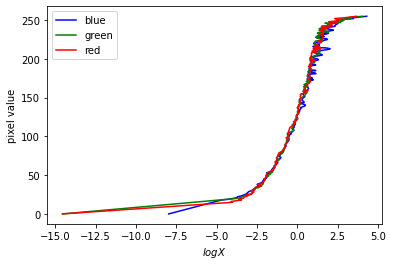

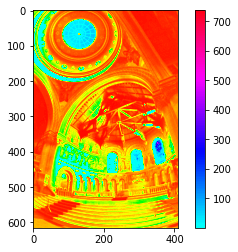

In [37]:
path = './data/images2'

# BGR Images
images = imread(path)
images = np.array([center_crop(x) for x in images])
blurs = np.array([cv2.GaussianBlur(img, (9, 9), 0) for img in images])
shutter_speed = np.log([32, 16, 8, 4, 2, 1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512, 1/1024])
# img3_shutter_speed = np.log([0.01, 0.02, 0.04, 1/13, 1/6, 1/3, 1, 2, 4, 8])
P = len(blurs)

indices = indices_sampling(blurs, size=50)

# Sampling images' pixel value in a (3 x N x P) form
Z = blurs.transpose(3, 1, 2, 0).reshape(3, -1, P)[:, indices]

G = []
for i in range(3):
    g, e = debevec(Z[i], shutter_speed, 0.1, get_windows())
    G.append(g)
plot_responsive_curves(G)
img = hdr_reconstruction(images, shutter_speed, G, get_windows())
plot_radiance_map(img, center_ratio=0.2)